In [ ]:
import numpy as np
import pandas as pd
import os
import re
import torch
import tensorflow as tf
import nltk
import pickle

from IPython import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from torch import nn

## **Load dataset**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Movie_dataset/IMDB Dataset.csv')
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0)

## **Vectorizer class**

In [ ]:
class Vectorizer:
    def __init__(self,):
        self.REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)(\')")
        self.REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer()
        self.glove = pd.read_csv('/content/drive/MyDrive/Movie_dataset/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
        self.glove_embedding = {key: val.values for key, val in self.glove.T.items()}
        self.MAX_LEN = 128

    def __remove_stop_words(self, corpus):
        english_stop_words = stopwords.words('english')
        removed_stop_words = []
        for review in corpus:
            removed_stop_words.append(
                ' '.join([word for word in review.split()
                          if word not in english_stop_words])
            )
        return removed_stop_words

    def clean_data(self, data):
        # data = [self.REPLACE_NO_SPACE.sub("", line.lower()) for line in data]
        data = [self.REPLACE_WITH_SPACE.sub(" ", line.lower()) for line in data]
        data = self.__remove_stop_words(data)
        return data

    def fit(self, data):
        self.tokenizer.fit_on_texts(data)

    def get_tokenizer(self):
        return self.tokenizer

    def create_embedding_matrix(self, embedding_dict=None, d_model=100):
        embedding_matrix = np.zeros((len(self.tokenizer.word_index) + 1, d_model))

        for word, index in self.tokenizer.word_index.items():
            if word in self.glove_embedding:
                embedding_matrix[index] = self.glove_embedding[word]
        return embedding_matrix


    def preprocess(self, data):
        data = self.tokenizer.texts_to_sequences(data)
        data = tf.keras.preprocessing.sequence.pad_sequences(data, maxlen=self.MAX_LEN)
        return data

## **Model class**

In [ ]:
class IMDBDataset:
    def __init__(self, reviews, targets):
        """
        Argument:
        reviews: a numpy array
        targets: a vector array

        Return xtrain and ylabel in torch tensor datatype, stored in dictionary format
        """
        self.reviews = reviews
        self.target = targets

    def __len__(self):
        # return length of dataset
        return len(self.reviews)

    def __getitem__(self, index):
        # given an idex (item), return review and target of that index in torch tensor
        review = torch.tensor(self.reviews[index,:], dtype = torch.long)
        target = torch.tensor(self.target[index], dtype = torch.float)

        return {'review': review,
                'target': target}

In [ ]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        """
        Given embedding_matrix: numpy array with vector for all words
        return prediction ( in torch tensor format)
        """
        super(LSTM, self).__init__()
        num_words = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding(
                                      num_embeddings=num_words,
                                      embedding_dim=embedding_dim)

        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(
                            embedding_dim,
                            64,
                            num_layers = 2,
                            bidirectional=True,
                            batch_first=True,
                            dropout = 0.8
                             )

        self.linear = nn.Linear(256, 1)
        self.out = nn.Sigmoid()



    def forward(self, x):

        x = self.embedding(x)
        hidden, _ = self.lstm(x)
        avg_pool= torch.mean(hidden, 1)
        max_pool, index_max_pool = torch.max(hidden, 1)
        out = torch.cat((avg_pool, max_pool), 1)
        out = self.out(self.linear(out))

        return out

## **Trainig fuctions, classes**

In [ ]:
class CheckPoint():
    def __init__(self, path):
        self.path = path
        self.val_ac = None

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


    def load_model(self, model):
        model.load_state_dict(torch.load(self.path))

    def after_epoch(self, val_ac, model):
        if self.val_ac is None:
            self.val_ac = val_ac
            self.save_checkpoint(model)
        elif self.val_ac > val_ac:
            self.val_ac = val_ac
            self.save_checkpoint(model)

In [ ]:
def train(data_loader, model, optimizer, device):
    final_predictions = []
    final_targets = []
    losses = 0
    accuracies = 0
    # set model to training mode
    model.train()
    # go through batches of data in data loader
    for data in data_loader:
        reviews = data['review']
        targets = data['target']
        # move the data to device that we want to use
        reviews = reviews.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.float)
        # clear the gradient
        optimizer.zero_grad()
        # make prediction from model
        predictions = model(reviews)

        loss = nn.BCELoss()(predictions, targets.view(-1,1))

        loss.backward()
        optimizer.step()

        predictions = predictions.cpu().detach().numpy().tolist()
        targets = targets.cpu().detach().numpy().tolist()

        losses += loss.item()
        outputs = np.array(predictions) >= 0.5
        accuracies += accuracy_score(targets, outputs)
    loss = losses/len(data_loader)
    accuracy = accuracies/len(data_loader)
    return accuracy, loss

In [ ]:
def evaluate(data_loader, model, device):
    final_predictions = []
    final_targets = []
    losses = 0
    accuracies = 0
    model.eval()
    # turn off gradient calculation
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            targets = data['target']
            reviews = reviews.to(device, dtype = torch.long)
            targets = targets.to(device, dtype=torch.float)

            predictions = model(reviews)

            loss = nn.BCELoss()(predictions, targets.view(-1,1))

            predictions = predictions.cpu().numpy().tolist()
            targets = targets.cpu().numpy().tolist()

            losses += loss.item()
            outputs = np.array(predictions) >= 0.5
            accuracies += accuracy_score(targets, outputs)
    loss = losses/len(data_loader)
    accuracy = accuracies/len(data_loader)
    return accuracy, loss


## **Main**

In [ ]:
vectorizer = Vectorizer()
df['review'] = vectorizer.clean_data(df['review'])

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=11)
train_df.index = range(len(train_df))
val_df.index = range(len(val_df))

In [ ]:
vectorizer.fit(train_df.review.values.tolist())

In [ ]:
embedding_matrix = vectorizer.create_embedding_matrix()

In [ ]:
xtrain = vectorizer.preprocess(train_df.review.values)
xtest = vectorizer.preprocess(val_df.review.values)

In [ ]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8

train_dataset = IMDBDataset(reviews=xtrain, targets=train_df.sentiment.values)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)

val_dataset = IMDBDataset(reviews=xtest, targets=val_df.sentiment.values)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_glove = LSTM(embedding_matrix)

model_glove.to(device)
optimizer = torch.optim.Adam(model_glove.parameters(), lr=1e-3)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Movie_dataset/movie_review_LSTM.pth'

CPU times: user 15min 20s, sys: 2min 4s, total: 17min 24s
Wall time: 18min 16s


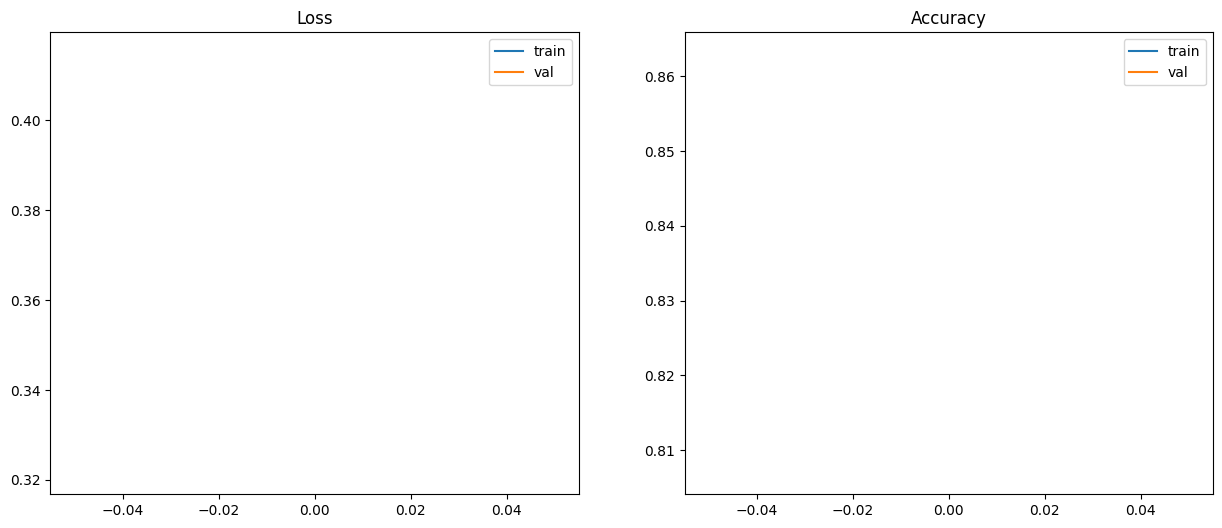

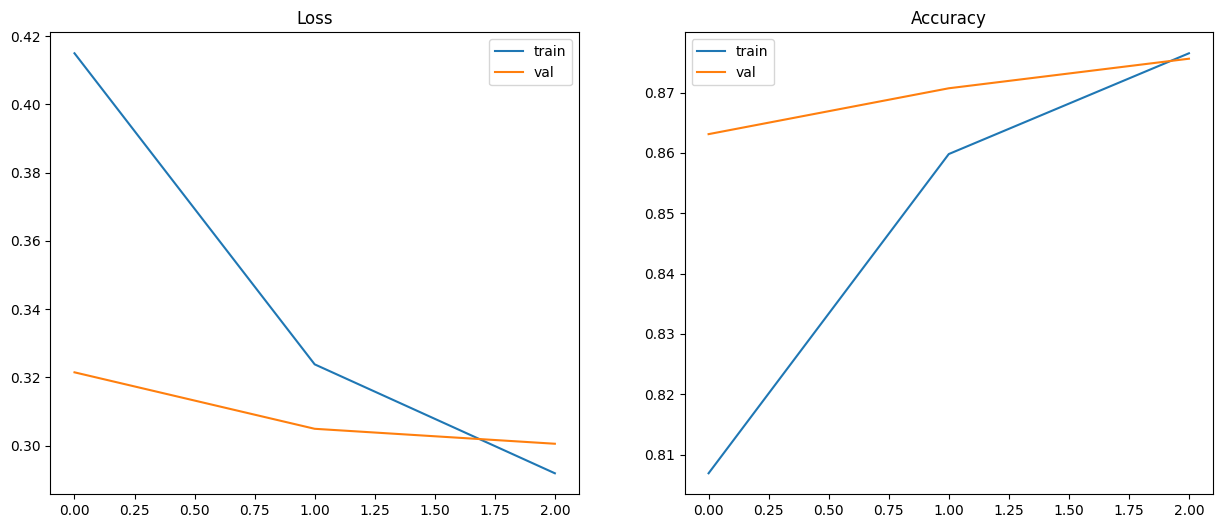

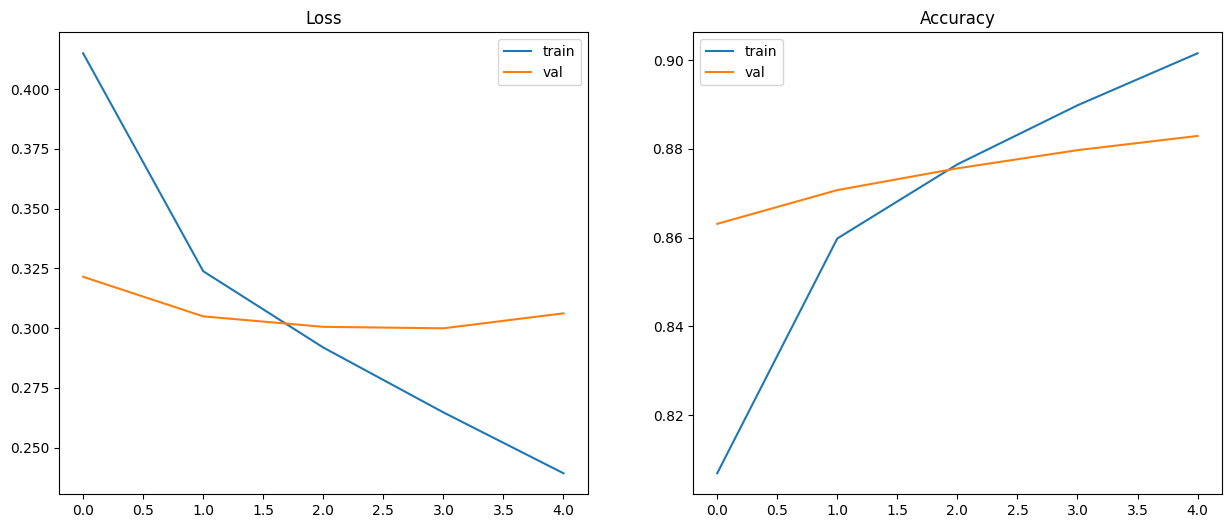

In [ ]:
%%time
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

checkpoint = CheckPoint(checkpoint_path)

for epoch in range(6):
    #train one epoch
    train_accuracy, train_loss = train(train_data_loader, model_glove, optimizer, device)

    val_accuracy, val_loss = evaluate(val_data_loader, model_glove, device)

    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    checkpoint.after_epoch(val_accuracy, model_glove)

    if epoch % 2 == 0:

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        axes[0].set_title('Loss')
        axes[0].plot(train_losses, label='train')
        axes[0].plot(val_losses, label='val')
        axes[0].legend()

        axes[1].set_title('Accuracy')
        axes[1].plot(train_accuracies, label='train')
        axes[1].plot(val_accuracies, label='val')
        axes[1].legend()

        display.display(fig)
        display.clear_output(wait=True)

In [ ]:
with open('embedding_matrix.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

tokenizer = vectorizer.get_tokenizer()
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)